# 2020-07-29

## Analyzing Rpb1-MS2 movies

I've processed 5 solid movies of Rpb1 and eve MS2 spots, improving the processing along the way. I need to try to analyze these movies now. I want to start with three questions:

1. Is Rpb1 enriched at transcription foci?
    Just generically and statically — taking the transcription foci in aggregate do we see Rpb1 enrichment?
2. Is there an association between transcription intensity and Rpb1 enrichment?
3. Is there a temporal relationship between Rpb1 signal and transcription activity:
    -cross-correlation type analysis between 1st derivative of txn signal and rpb1.
    -triggered-averaging of txn signal to rpb1 high-low-med


In [1]:
# Import public packages.
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi 
from importlib import reload
import pickle
import czifile
%matplotlib inline

# Import my packages.
import sys
sys.path.append('/Users/MStadler/Bioinformatics/Projects/Zelda/Quarantine_analysis/bin')
import imagep as imp
reload(imp)
from imagep import viewer, save_pickle, load_pickle, box_spots, read_czi

In [2]:
mv1 = load_pickle('/Users/MStadler/Bioinformatics/Projects/Zelda/Quarantine_analysis/results/20200717-rd2-em1-zmv-03.pkl')

mv2 = load_pickle('/Users/MStadler/Bioinformatics/Projects/Zelda/Quarantine_analysis/results/20200717-rd2-em1-zmv-04.pkl')

mv3 = load_pickle('/Users/MStadler/Bioinformatics/Projects/Zelda/Quarantine_analysis/results/20200717-rd2-em1-zmv-06.pkl')

mv4 = load_pickle('/Users/MStadler/Bioinformatics/Projects/Zelda/Quarantine_analysis/results/20200720-em4-zsmv-07.pkl')

mv5 = load_pickle('/Users/MStadler/Bioinformatics/Projects/Zelda/Quarantine_analysis/results/20200720-em4-zsmv-09.pkl')



In [79]:
mv6 = load_pickle('/Users/MStadler/Bioinformatics/Projects/Zelda/Quarantine_analysis/results/20200729-em1-zsmv-06.pkl')

In [2]:
from skimage.filters.thresholding import threshold_li, threshold_otsu

def mask_rpb1_foci(stack, mask, sigma1=3, dilation_len=10):
    """Mask Rpb1 foci within nuclei"""
    mask_foci = np.zeros_like(stack)
    for i in range(0, stack.shape[0]):
        maxp = stack[i].max(axis=0)
        im_smooth = ndi.filters.gaussian_filter(maxp, sigma=sigma1)
        # Make second mask of pol2 foci (presumed HLBs) by re-thresholding within nuclei.
        t_foci = threshold_otsu(im_smooth[mask[i,0].astype('bool')])
        mask_2d = np.where(im_smooth > t_foci, True, False)
        mask_2d = ndi.morphology.binary_dilation(mask_2d, structure=np.ones((dilation_len, dilation_len)))
        mask_3d = np.repeat([mask_2d], stack.shape[1], axis=0)
        mask_foci[i] = mask_3d
    return mask_foci.astype('bool')

#a=mask_rpb1_foci(mv.stack[0], mv.nucmask)

In [3]:
from random import random
def random_spot_data(spot_data, mask, n):
    """Produce spot_data for spots in random positions within nuclei, constrained by HLB mask"""
    rand_spot_data = {}
    for spot in spot_data:
        rand_spot_data[spot] = np.ndarray((spot_data[spot].shape[0] * n, spot_data[spot].shape[1]))
        rownum=0
        arr = spot_data[spot]
        for row in arr:
            t, nuc, z = [int(x) for x in row[0:3]]
            x,y = np.where(mask[t,z] == nuc)
            numpix = len(x)
            for i in range(0, n):
                rand = int(numpix * random())
                randx, randy = x[rand], y[rand]
                newrow = row.copy()
                newrow[3:5] = [randx, randy]
                rand_spot_data[spot][rownum] = newrow
                rownum = rownum + 1
    return rand_spot_data
#e=random_spot_data(mv.spot_data, np.where(a, 0, mv.nucmask),2)

In [80]:
mv = mv6
hlb_mask = mask_rpb1_foci(mv.stack[0], mv.nucmask)
nucmask_masked = np.where(hlb_mask, 0, mv.nucmask)
rand_data = random_spot_data(mv.spot_data, nucmask_masked, 5)
true_ms2 = imp.spot_movies(mv.stack, mv.spot_data, channel=1, fill=0, len_ij=31, view=False)
true_prot = imp.spot_movies(mv.stack, mv.spot_data, channel=0, fill=0, len_ij=31, view=False)
rand_ms2 = imp.spot_movies(mv.stack, rand_data, channel=1, fill=0, len_ij=31, view=False)
rand_prot = imp.spot_movies(mv.stack, rand_data, channel=0, fill=0, len_ij=31, view=False)

In [4]:
def project(x):
    x1 = x[:,:,2:5].sum(axis=2).sum(axis=1).sum(axis=0)
    x1 = x1 / x1.max() * x1.shape[0]
    return x1
viewer([project(true_ms2), project(rand_ms2)])

NameError: name 'true_ms2' is not defined

In [82]:
viewer([project(true_prot), project(rand_prot)])

interactive(children=(Dropdown(description='Color', index=5, options=('prism', 'Greens', 'cividis', 'plasma', …

In [5]:
def sum_true(a, channel):
    sum_ = project(imp.spot_movies(a[0].stack, a[0].spot_data, channel=channel, fill=0, len_ij=31, view=False))
    for i in range(0, len(a)):
        sum_ = sum_ + project(imp.spot_movies(a[i].stack, a[i].spot_data, channel=channel, fill=0, len_ij=31, view=False))
    return sum_
truems2=sum_true([mv1, mv2, mv3, mv4, mv5],1)

NameError: name 'mv1' is not defined

In [6]:
def sum_false(a, channel):
    hlb_mask = mask_rpb1_foci(a[0].stack[0], a[0].nucmask)
    nucmask_masked = np.where(hlb_mask, 0, a[0].nucmask)
    rand_data = random_spot_data(a[0].spot_data, nucmask_masked, 1)
    sum_ = project(imp.spot_movies(a[0].stack, rand_data, channel=channel, fill=0, len_ij=31, view=False))
    for i in range(0, len(a)):
        hlb_mask = mask_rpb1_foci(a[i].stack[0], a[i].nucmask)
        nucmask_masked = np.where(hlb_mask, 0, a[i].nucmask)
        rand_data = random_spot_data(a[i].spot_data, nucmask_masked, 1)
        sum_ = sum_ + project(imp.spot_movies(a[i].stack, rand_data, channel=channel, fill=0, len_ij=31, view=False))
    return sum_
falseprot=sum_false([mv1, mv2, mv3, mv4, mv5],0)

NameError: name 'mv1' is not defined

In [77]:
falseprot.max()

182.2371003313624

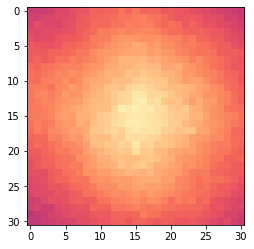

In [78]:
plt.imshow(falseprot,cmap="magma",vmin=90, vmax=185)
#viewer(falseprot)

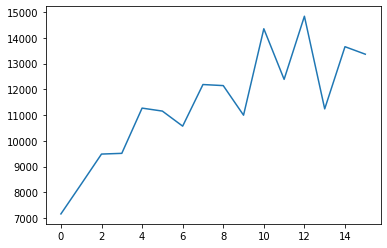

In [90]:
mv6.intvol.mean(axis=1).plot()

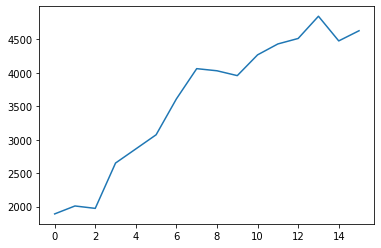

In [91]:
mv6.prot.mean(axis=1).plot()

In [96]:
nucsig = []
for i in range(0, 16):
    print(i)
    pix = mv6.stack
    nucsig.append(np.mean(mv6.stack[0,i][mv6.nucmask[i].astype('bool')]))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


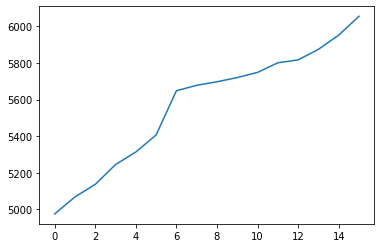

In [97]:
plt.plot(nucsig)

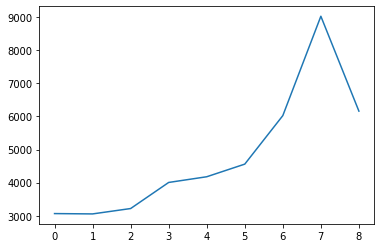

In [125]:
mv6.prot.iloc[:,3].plot()

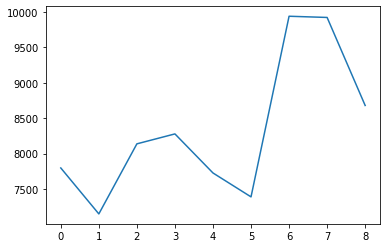

In [124]:
mv6.intvol.iloc[:,3].plot()

In [128]:
viewer([true_ms2,true_prot])

interactive(children=(Dropdown(description='Color', index=5, options=('prism', 'Greens', 'cividis', 'plasma', …

In [136]:
viewer(true_prot[9].mean(axis=0))

interactive(children=(Dropdown(description='Color', index=5, options=('prism', 'Greens', 'cividis', 'plasma', …

In [185]:
mv = mv3
hlb_mask = mask_rpb1_foci(mv.stack[0], mv.nucmask)
nucmask_masked = np.where(hlb_mask, 0, mv.nucmask)
rand_data = random_spot_data(mv.spot_data, nucmask_masked, 5)
true_ms2 = imp.spot_movies(mv.stack, mv.spot_data, channel=1, fill=0, len_ij=31, view=False)
true_prot = imp.spot_movies(mv.stack, mv.spot_data, channel=0, fill=0, len_ij=31, view=False)
rand_ms2 = imp.spot_movies(mv.stack, rand_data, channel=1, fill=0, len_ij=31, view=False)
rand_prot = imp.spot_movies(mv.stack, rand_data, channel=0, fill=0, len_ij=31, view=False)

In [189]:
viewer([true_prot.mean(axis=1).mean(axis=0), true_prot.mean(axis=0).mean(axis=0)])
#mv.intvol

interactive(children=(Dropdown(description='Color', index=5, options=('prism', 'Greens', 'cividis', 'plasma', …

In [166]:
imp.quickview_ms2(mv1.stack, mv1.spot_data)

interactive(children=(Dropdown(description='Color', index=5, options=('prism', 'Greens', 'cividis', 'plasma', …

In [167]:
imp.quickview_ms2(mv6.stack, mv6.spot_data)

interactive(children=(Dropdown(description='Color', index=5, options=('prism', 'Greens', 'cividis', 'plasma', …

### Observation:

With eve, the single-spot time-averages (average the Rpb1 frame over all time frames for a single spot) shows more nuclear edges than Hb. If it holds up...differences in nuclear localization for hb and eve? Both genes have similar positions relative to centromeres. Could be a nuclear cycle thing, where earlier nuclei have more movement and thus the dots either move enough to average edge signal out or just don't stay by the edge. Looking at the above movies, it's not apparent there's a difference in mobility. We would need to do comparisons of the same nuclear cycle.

OK, let's get to the meat. Is there a relationship between pol2 occupancy and ms2 traces? Let's start by looking at some traces.

In [228]:
mv1.intvol

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,26741.730435,1854.815789,8856.713043,4765.938596,8009.684211,5903.929825,5688.570175,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,8994.000000,9629.278261,4670.938596,8431.947368,7032.912281,NaN,8505.339130,7675.347826,8058.850877,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,39056.217391,7615.868421,8713.504348,5777.815789,7836.131579,5884.333333,6536.482456,9736.339130,8164.678261,8169.315789,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,9499.313043,7398.947368,8435.878261,4962.570175,9930.878261,7246.184211,6548.859649,6297.104348,7903.565217,8479.254386,8690.771930,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,7982.473684,8311.473684,NaN,9332.491228,8233.289474,6625.184211,NaN,8022.234783,8748.780702,7672.798246,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,7195.728070,8226.570175,5971.947368,9089.208696,6645.017544,6709.491228,NaN,7537.026087,8918.508772,8371.552632,7311.026316,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,7084.885965,NaN,9596.280702,NaN,7724.056604,NaN,NaN,NaN,8820.114035,8088.500000,5058.704348,7395.333333,NaN,NaN,NaN,NaN
7,NaN,NaN,8182.429825,NaN,9203.850877,8538.570175,6523.562500,NaN,NaN,7935.473684,NaN,8151.649123,5896.869565,8018.605263,4901.403509,7370.164948,NaN,NaN
8,NaN,NaN,NaN,NaN,8265.736842,NaN,6534.609375,NaN,NaN,NaN,9815.543860,7470.745614,5896.394737,7702.552632,6682.105263,8423.965116,NaN,NaN
9,NaN,NaN,NaN,NaN,8789.745614,7177.342105,NaN,NaN,NaN,NaN,NaN,8471.780702,NaN,7851.938596,7557.210526,8028.350877,2657.359649,1889.578125


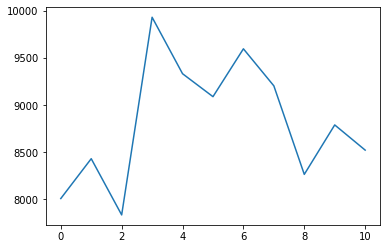

In [211]:
mv1.intvol[5].plot()

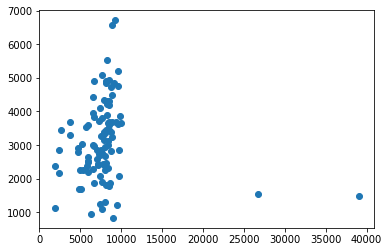

In [225]:
plt.scatter(mv1.intvol, mv1.prot)

In [226]:
mv1.intvol[1]

0     26741.730435
1              NaN
2     39056.217391
3      9499.313043
4              NaN
5              NaN
6              NaN
7              NaN
8              NaN
9              NaN
10             NaN
11             NaN
Name: 1, dtype: float64

In [223]:
imp.quickview_ms2(mv2.stack, mv2.spot_data, 0, 1)

interactive(children=(Dropdown(description='Color', index=5, options=('prism', 'Greens', 'cividis', 'plasma', …

# WARNING:

All the movies are wrong! I had the channels backwards in the processing script (because the channels are reversed from lattice data) so intvol and protein are swapped. Will fix now.

In [4]:
mv = mv6

prot = mv.intvol.copy()
intvol = mv.prot.copy()
mv.intvol = intvol
mv.prot = prot

save_pickle(mv, '/Users/MStadler/Bioinformatics/Projects/Zelda/Quarantine_analysis/results/20200729-em1-zsmv-06.pkl')

In [3]:
mv1 = load_pickle('/Users/MStadler/Bioinformatics/Projects/Zelda/Quarantine_analysis/results/20200717-rd2-em1-zmv-03.pkl')

mv2 = load_pickle('/Users/MStadler/Bioinformatics/Projects/Zelda/Quarantine_analysis/results/20200717-rd2-em1-zmv-04.pkl')

mv3 = load_pickle('/Users/MStadler/Bioinformatics/Projects/Zelda/Quarantine_analysis/results/20200717-rd2-em1-zmv-06.pkl')

mv4 = load_pickle('/Users/MStadler/Bioinformatics/Projects/Zelda/Quarantine_analysis/results/20200720-em4-zsmv-07.pkl')

mv5 = load_pickle('/Users/MStadler/Bioinformatics/Projects/Zelda/Quarantine_analysis/results/20200720-em4-zsmv-09.pkl')

mv6 = load_pickle('/Users/MStadler/Bioinformatics/Projects/Zelda/Quarantine_analysis/results/20200729-em1-zsmv-06.pkl')





In [6]:
viewer(mv1.stack)

interactive(children=(Dropdown(description='Color', index=3, options=('Greens', 'cividis', 'prism', 'viridis',…

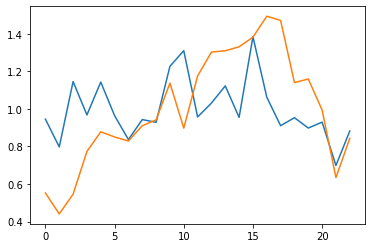

In [50]:
s=4
mv=mv5
(mv.prot[s] / mv.prot[s].mean()).plot() #blue
(mv.intvol[s] / mv.intvol[s].mean()).plot() #orange

In [57]:
mv.intvol[2]

0     4796.208696
1     5703.713043
2     5448.800000
3     4711.469565
4     5280.452174
5     4664.826087
6     4952.400000
7     1970.069565
8     3543.791304
9     3558.582609
10    2902.600000
11    2243.626087
12    2036.800000
13    2278.147826
14    2170.443478
15    2554.721739
16            NaN
17    1773.156522
18    1759.486957
19    1436.113043
20    1630.878261
21    2080.452174
22    2425.217391
Name: 2, dtype: float64

In [61]:
mv.intvol[2].rolling(3, center=True).mean()

0             NaN
1     5316.240580
2     5287.994203
3     5146.907246
4     4885.582609
5     4965.892754
6     3862.431884
7     3488.753623
8     3024.147826
9     3334.991304
10    2901.602899
11    2394.342029
12    2186.191304
13    2161.797101
14    2334.437681
15            NaN
16            NaN
17            NaN
18    1656.252174
19    1608.826087
20    1715.814493
21    2045.515942
22            NaN
Name: 2, dtype: float64

In [63]:
mv.intvol[2].rolling(3, center=True).mean().diff(2)

0             NaN
1             NaN
2             NaN
3     -169.333333
4     -402.411594
5     -181.014493
6    -1023.150725
7    -1477.139130
8     -838.284058
9     -153.762319
10    -122.544928
11    -940.649275
12    -715.411594
13    -232.544928
14     148.246377
15            NaN
16            NaN
17            NaN
18            NaN
19            NaN
20      59.562319
21     436.689855
22            NaN
Name: 2, dtype: float64

In [105]:
#mv = stitch
def findrises(df, windowsize, lag, threshold, rise=True):
    events = []
    for spot in df:
        data = df[spot]
        data_norm = (data - data.min()) / (data.max() - data.min())
        rolling_avg = data_norm.rolling(windowsize).mean()
        diff = rolling_avg.diff(lag)
        if rise:
            indices = np.where(diff > threshold)
        else:
            indices = np.where(diff < (-1 * threshold))
        for i in indices[0]:
            events.append([spot, i])
    return events

In [160]:
mv=mv5
test=findrises(mv.prot, 3, 2, 0.3, True)

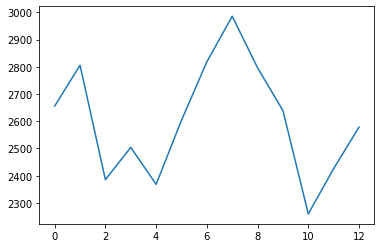

In [161]:
imp.align_traces(mv.intvol, test, 13).mean().plot()

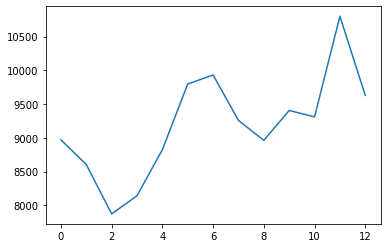

In [162]:
imp.align_traces(mv.prot, test, 13).mean().plot()

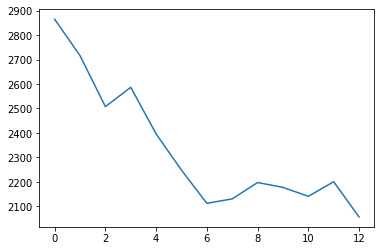

In [154]:
mv=mv5
test=findrises(mv.prot, 3, 2, 0.2, False)
imp.align_traces(mv.intvol, test, 13).mean().plot()

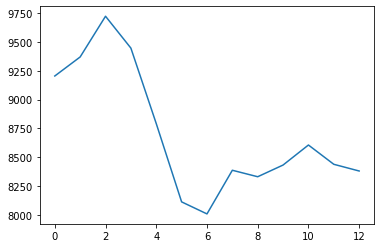

In [155]:
imp.align_traces(mv.prot, test, 13).mean().plot()

In [167]:
mv5.intvol

,1,2,3,4,5,6,7,8,9,10,...,47,48,49,50,51,52,53,54,55,56
0,3299.443478,4796.208696,3792.095652,1249.747826,1231.704348,4344.026087,2596.530435,3497.843478,2586.008696,3236.565217,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3150.669565,5703.713043,3842.052174,997.243478,1133.278261,4471.017391,3556.382609,3515.730435,2714.965217,3030.886957,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3032.713043,5448.800000,4276.278261,1235.043478,1319.678261,3219.121739,3684.817391,2938.086957,1562.252174,3391.347826,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2195.565217,4711.469565,3112.513043,1750.113043,1466.443478,3528.843478,3713.504348,2412.573913,2533.939130,3138.200000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2148.165217,5280.452174,3645.121739,1987.634783,1566.938596,4029.469565,3390.695652,2568.060870,2347.069565,3484.443478,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,4664.826087,2805.443478,1924.965217,NaN,1611.321739,3394.095652,2249.730435,2389.339130,3099.765217,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,1503.147826,4952.400000,3142.747826,1876.634783,1524.773913,3837.095652,3837.069565,2795.104348,2659.330435,3713.269565,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,1461.930435,1970.069565,2860.608696,2060.695652,1396.921739,4253.069565,3451.226087,2604.043478,3098.417391,3295.721739,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,3543.791304,1870.782609,2131.600000,1227.913043,3424.391304,3046.547826,3017.086957,2828.069565,3888.826087,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,3558.582609,2272.426087,2574.756522,1510.313043,3678.104348,3670.965217,2617.913043,2298.678261,4048.252174,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Needed:

So I think the thing I need for doing really interesting analysis is long time-scales, like the Augusto movies. I set up some eve+Rpb1 cages with the intent of doing some long collections in the Augusto style. Will be useful to play around with field-of-view and laser power to see what I can get with decent time resolution and not over-bleach the Rpb1 signal. Goal is to get movies that are like 40+ frames at ~17 seconds, so maybe 12 minutes+ or so. This could certainly also work with Sna (I remember hearing Hb doesn't burst much). I think these would at least be a useful comparison to tie things together to Garcia lab work. 

OK, trying to look at Rpb1 vs. MS2 signal.

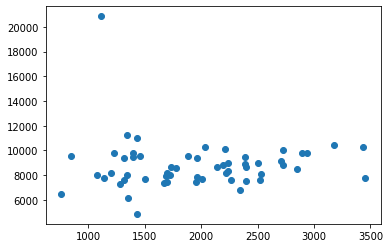

In [178]:
# Plotting mean of spot protein signal (over all time frames) vs. mean of MS2 signal
# Are brighter MS2 spots associated with more Rpb1?
plt.scatter(mv5.intvol.mean(axis=0), mv5.prot.mean(axis=0))

Hmm, not much there. I have a mid-nc14 (actually late) dataset. Processed one and loaded as mv7. Plotting MS2 vs. protein for many spots:

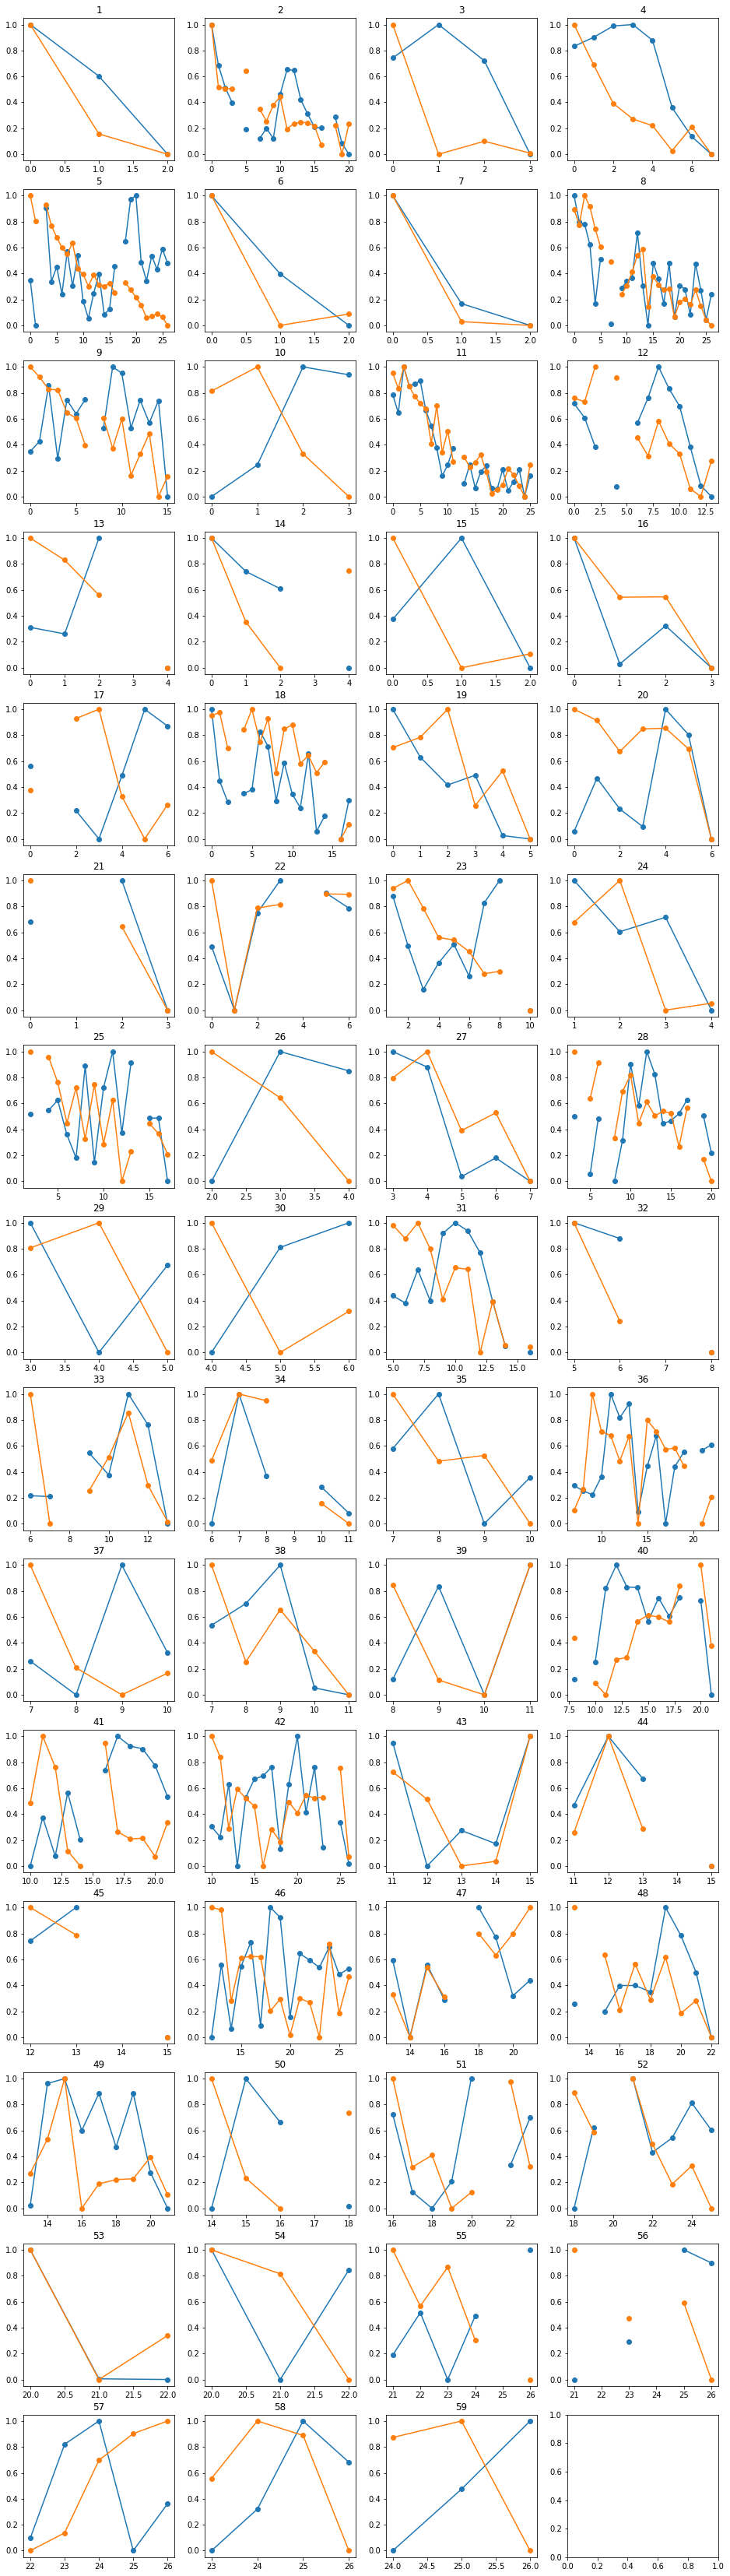

In [207]:
#mv7 = load_pickle('/Users/MStadler/Bioinformatics/Projects/Zelda/Quarantine_analysis/results/20200720-em5-zsmv-01.pkl')
def plot_prot_ms2_multspots(mv):
    num_to_plot= mv.intvol.shape[1]

    def norm(x):
        return (x - x.min()) / (x.max() - x.min())

    def test(x):
        norm(mv.intvol[x]).plot(marker="o") #blue
        norm(mv.prot[x]).plot(marker="o") #orange
        plt.title(x)
    imp.plot_ps(test, range(1,num_to_plot+1))
    
plot_prot_ms2_multspots(mv7)

Hmmm. This is quite interesting. What about mv4 and mv5, the other ones with decent traces?

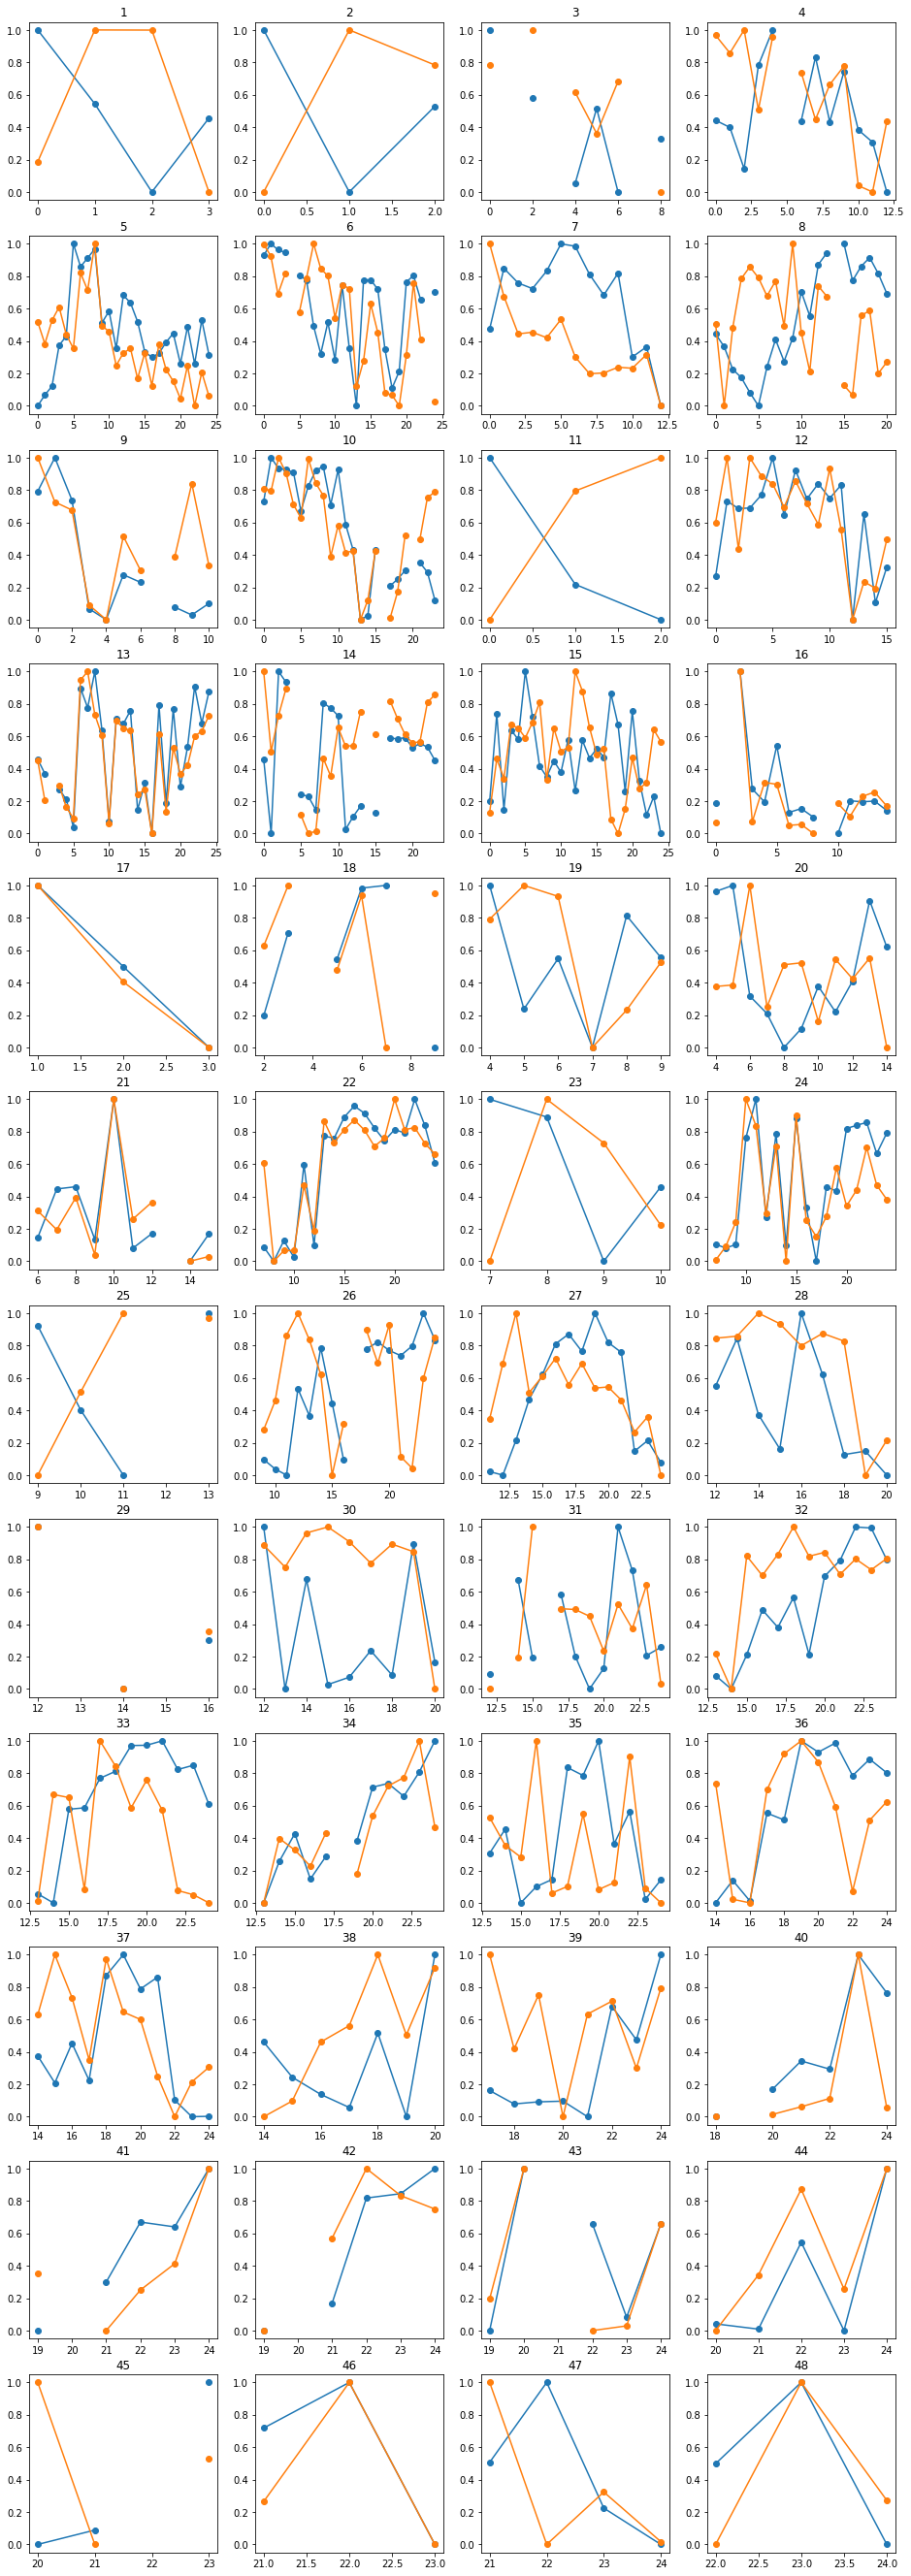

In [208]:
plot_prot_ms2_multspots(mv4)

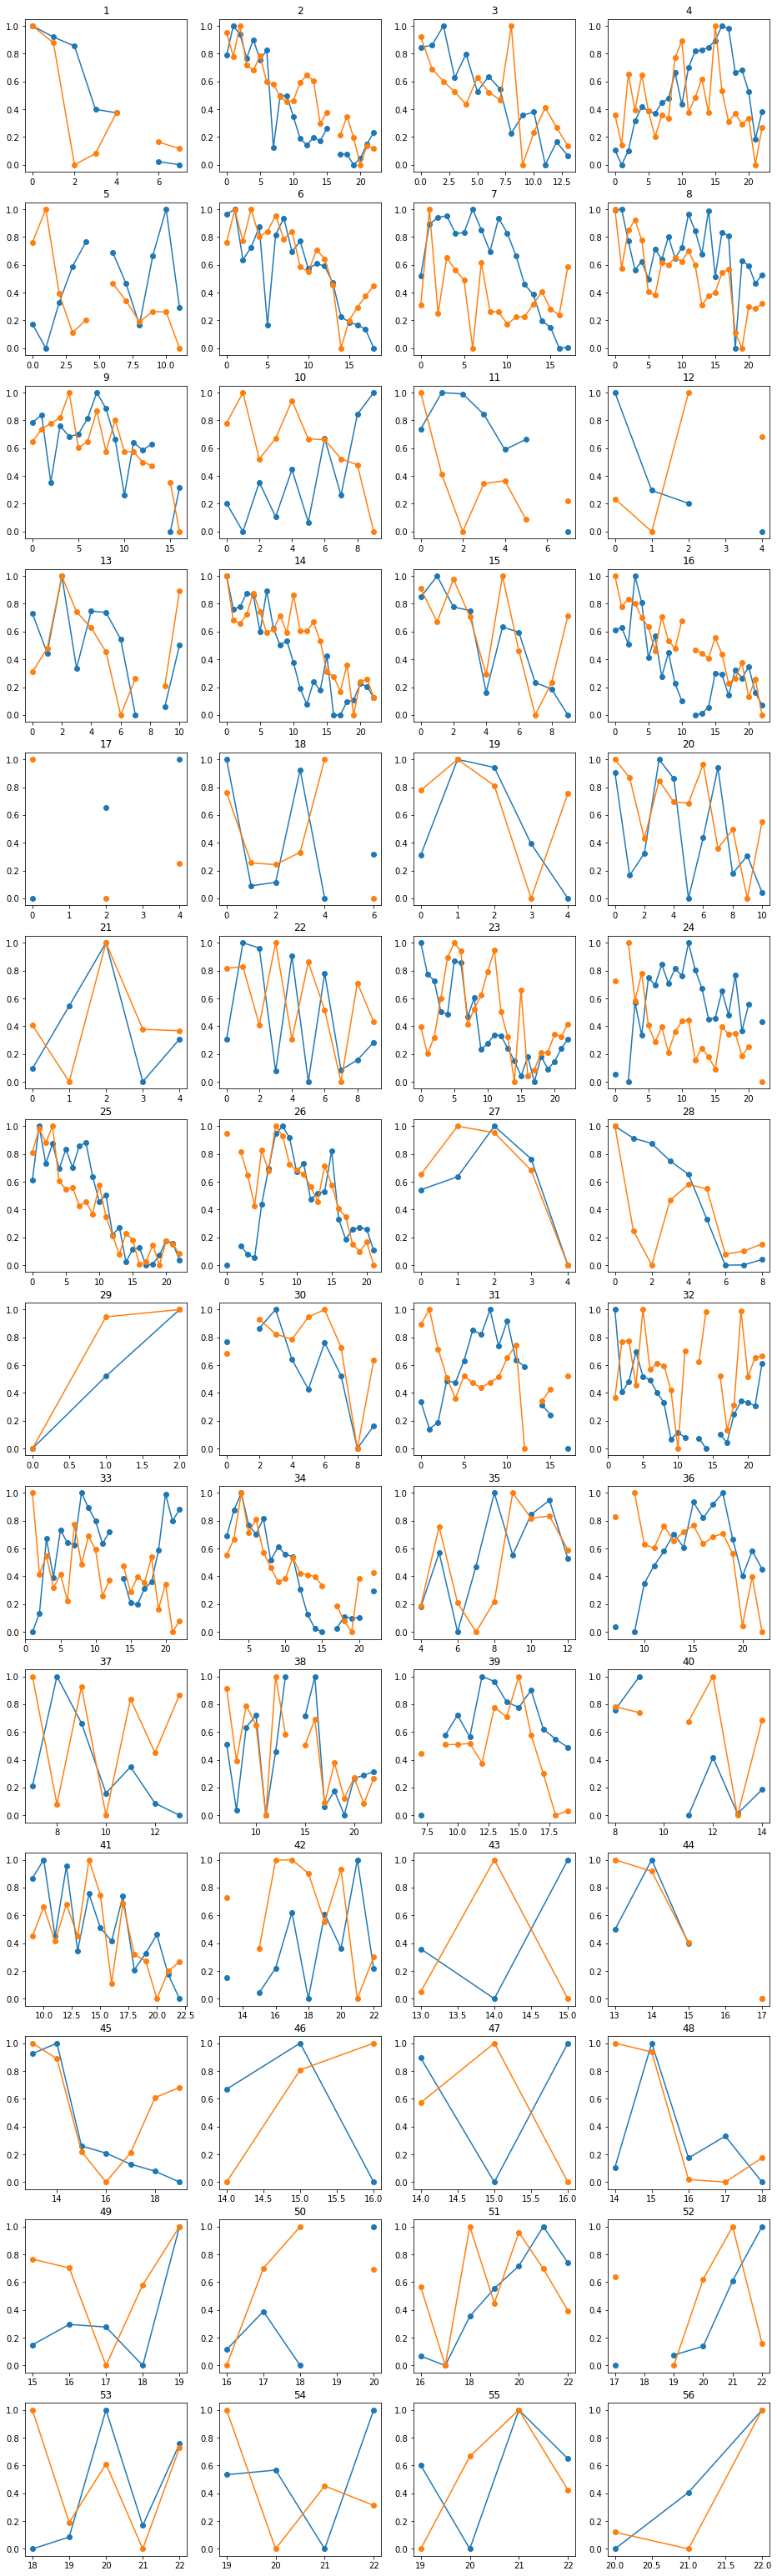

In [209]:
plot_prot_ms2_multspots(mv5)

This is fascinating. Some of these follow each other EERILY, close enough to make me say that has to be an artefact (there should be a time lag if it's real, no?). Am I seeing bleedthrough? Something else? In other cases there seems to be no relationship at all. Very curious. Going to examing the movies of some key spots.

Also: remember Rpb1 signal bleaches some in these movies, and a bunch of spots are going off, so the ones where they both decline could be this?

In [217]:
reload(imp)
imp.quickview_ms2(mv5.stack, mv5.spot_data, 0, 26)

interactive(children=(Dropdown(description='Color', index=3, options=('Greens', 'cividis', 'prism', 'viridis',…

Hard to tell here. Definitely looks like MS2 changes are legit, and protein changes don't seem to be any funny business (tracking errors, etc.).

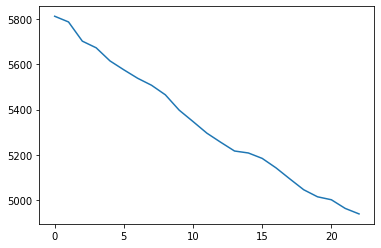

In [221]:
# Total decline of signal.
t=mv5.stack[0]
t=t.mean(axis=1).mean(axis=1).mean(axis=1)
plt.plot(t)

So signal definitely goes down...but not clear by how much. Hmm. Glancing at the movie in the viewer, and bleaching definitely happens over the movie. Some o the most compelling examples are cases like mv4 spots 5 and 13, where what look like MS2 bursts are accompanied by Rpb1 changes. Something seems off about this. They're too perfect...will look at in viewer.

In [227]:
reload(imp)
imp.quickview_ms2(mv4.stack, mv4.spot_data, 1, 13)

interactive(children=(Dropdown(description='Color', index=3, options=('Greens', 'cividis', 'prism', 'viridis',…

In [228]:
help(imp.spot_movies)

Help on function spot_movies in module imagep:

spot_movies(stack, spot_data, channel=0, len_ij=15, len_z=7, fill=nan, view=True)
    Make image stack for viewing MS2 spot raw data
    
    Given spot coordinates and original movie, builds an image stack with 
    spot ID on the first dimension and raw data centered on the spot in the
    remaining three. In cases where the window exceeds the boundaries of the
    image, the remaining portions of the frame will be filled by the value
    specified by fill.
    
    Args:
        stack: ndarray
            5-D image stack [c,t,z,x,y]
        spot_data: dict of ndarrays
            Data containing tracking of spots detected. Dict entries are unique 
            spot IDs (numeric 1...), rows of ndarray are detections of the spot 
            in a single frame. Required columns: 5: gaussian fit height, 6: 
            gaussian fit z-width, 7: gaussian fit x-width, 8: gaussian fit 
            y-width.
        channel: int
            Chann

In [236]:
ms2 = imp.spot_movies(mv4.stack, mv4.spot_data,1, fill=0, len_ij=31, view=False)
p = imp.spot_movies(mv4.stack, mv4.spot_data,0, fill=0, len_ij=31,view=False)

In [240]:
viewer(p)

interactive(children=(Dropdown(description='Color', index=3, options=('Greens', 'cividis', 'prism', 'viridis',…